In [1]:
import sys
sys.path.append('..')
from glob import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt


In [15]:
hf_val = h5py.File('/home/willbo/data/dcase/hfiles/val/a1.h5')
hf_test = h5py.File('/home/willbo/data/dcase/hfiles/test/DC12.h5')

In [21]:
val_paths = glob('/home/willbo/data/dcase/hfiles/val/*.h5')
test_paths = glob('/home/willbo/data/dcase/hfiles/test/*.h5')

In [16]:
print('Positive examples validation file: '+str(len(hf_val['feat_pos'][:])))
print('Positive examples test file: '+str(len(hf_test['feat_pos'][:])))

Positive examples validation file: 103
Positive examples test file: 427


In [31]:
val_l = []
for file in val_paths:
    hf = h5py.File(file)
    val_l += [len(hf['feat_pos'][:])]
    hf.close()
    
test_l = []
for file in test_paths:
    hf = h5py.File(file)
    test_l += [len(hf['feat_pos'][:])]
    hf.close()
    
print('Mean/std number of positive examples validation set: '+str(np.mean(val_l))+' ('+str(np.var(val_l))+')')
print('Mean/std number of positive examples test set: '+str(np.mean(test_l))+' ('+str(np.var(test_l))+')')

Mean/std number of positive examples validation set: 42.875 (4058.359375)
Mean/std number of positive examples test set: 79.3225806451613 (16828.21852237253)


/tmp/ipykernel_3493418/550323436.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plt.boxplot(np.array([val_l, test_l]))


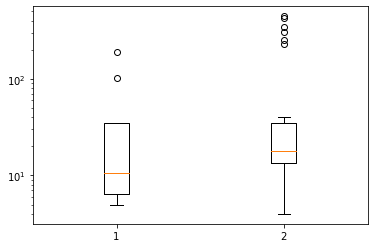

In [29]:
fig = plt.boxplot(np.array([val_l, test_l]))
plt.yscale('log')

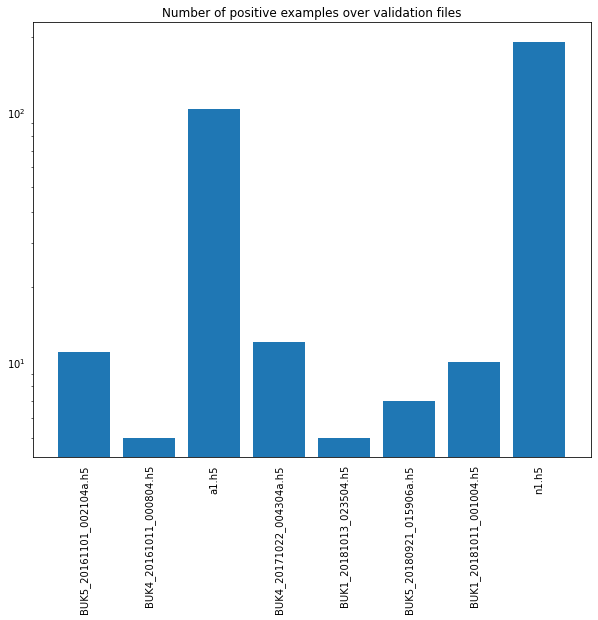

In [63]:
plt.figure(figsize=(10,8))
ticklabels = list(map(lambda s: s.split('/')[-1], val_paths))
plt.bar(range(len(val_l)), val_l, tick_label=ticklabels)
plt.xticks(rotation=90)
plt.gca().tick_params(axis='x', color='white')
plt.gca().tick_params(axis='y', color='white')
plt.title('Number of positive examples over validation files')
plt.yscale('log')
plt.savefig('nrposvalfiles.pdf')

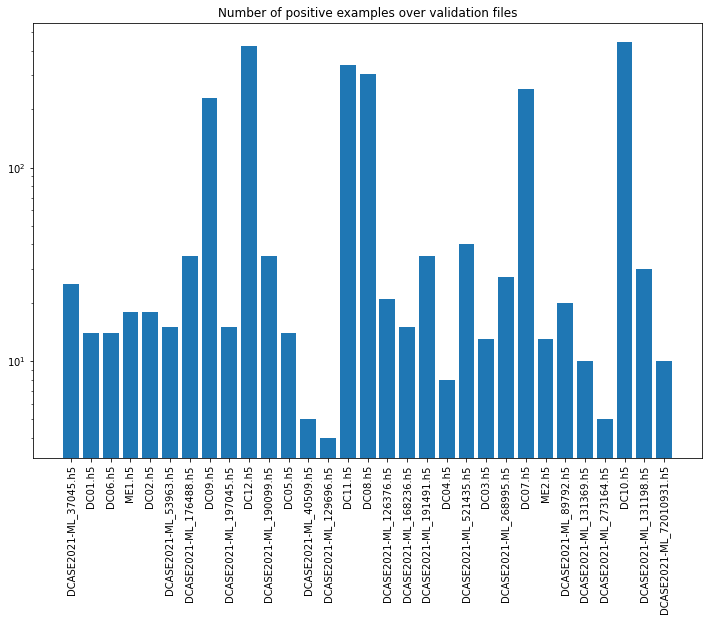

In [64]:
plt.figure(figsize=(12,8))
ticklabels = list(map(lambda s: s.split('/')[-1], test_paths))
plt.bar(range(len(test_l)), test_l, tick_label=ticklabels)
plt.xticks(rotation=90)
plt.title('Number of positive examples over validation files')
plt.yscale('log')
plt.savefig('nrpostestfiles.pdf')

In [5]:
import torch

torch.stack([torch.tensor([1,10,20]),torch.tensor([2,11,21])]).view(-1)


tensor([ 1, 10, 20,  2, 11, 21])

### Multithreading thinking

So the method below works fine and dandy for odd window lengths.
I don't know how the filtering method handles this internally. But it's no big deal
to just increment the window size by 1 if it is even.

In [59]:
def f(x):
    
    print(':'+str(x[1])+':')
    return list(x[1]+1)

In [60]:
from multiprocessing import Pool
import math
import numpy as np

a = np.array([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4])
n_proc = 3
w_size = 3
d = math.floor(len(a)/n_proc)
ix = []
for i in range(n_proc):
    if i == (n_proc-1):
        ix += [list(range(i*d-int((w_size-1)/2), len(a)))]
    else:    
        ix += [list(range(max(0, i*d-int((w_size-1)/2)), (i+1)*d+int((w_size-1)/2)))]

pool = Pool(processes=n_proc)
out = pool.map(f, [(i, a[e]) for i, e in enumerate(ix)])

:[1 1 2 2 2 3 3]::[0 0 0 1 1 1]::[3 3 3 4 4 4]:




In [69]:
print(out)
print(a)
n_out = []
for i in range(len(out)):
    if i == 0:
        n_out += [out[i][0:len(out[i])-int((w_size-1)/2)]]
    elif i == len(out)-1:
        n_out += [out[i][int((w_size-1)/2):len(out[i])]]
    else:
        n_out += [out[i][int((w_size-1)/2):len(out[i])-int((w_size-1)/2)]]
        
print((np.array(n_out).flatten() == f((0,a))).all())


[[1, 1, 1, 2, 2, 2], [2, 2, 3, 3, 3, 4, 4], [4, 4, 4, 5, 5, 5]]
[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]
:[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]:
True


In [6]:
import math
import numpy as np
import torch
from torch.nn import functional as F

d = torch.tensor(np.random.random((100,20)))

t = torch.zeros(0)
t = torch.cat((t, torch.tensor(0).reshape(1)))
t = torch.cat((t, torch.tensor(1).reshape(1)))
t.mean()


torch.sum(d**2)
d.item()

ValueError: only one element tensors can be converted to Python scalars

In [2]:
import numpy as np
l = ['aa', 'bc', 'dddd', 'eed', 'ffff']
np.random.choice(l)

'dddd'

In [3]:
import os
from glob import glob

In [4]:
path = '/home/willbo/data/TUT/TUT1'
wav_files = [file for file in glob(os.path.join(path, '*.wav'))]

In [8]:
for file in wav_files:
    f = open(file.replace('wav', 'csv'), 'w')
    f.write('Starttime,Endtime')
    f.close()

In [18]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from models import prototypical

In [38]:
model = models.resnet18(pretrained=True)

In [36]:
def basic_block(in_channels_1, out_channels_1, in_channels_2, out_channels_2, stride_1, stride_2, downsample=False):
    if not downsample:
        return nn.Sequential(
            nn.Conv2d(in_channels_1, out_channels_1, kernel_size = 3, stride = stride_1, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels_1, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels_2, out_channels_2, kernel_size = 3, stride = stride_2, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels_2, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels_1, out_channels_1, kernel_size = 3, stride = stride_1, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels_1, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels_2, out_channels_2, kernel_size = 3, stride = stride_2, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels_2, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            nn.Sequential(
                nn.Conv2d(int(out_channels_2/2), out_channels_2, kernel_size = 1, stride = 2, bias = False),
                nn.BatchNorm2d(out_channels_2, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)    
            )
        )

In [37]:
channel_base = 128
kernel_base = 3

model.conv1 = nn.Conv2d(1, channel_base, kernel_size = kernel_base, stride = 1, padding = 1, bias = False)
model.bn1 = nn.BatchNorm2d(channel_base, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)

model.layer1 = nn.Sequential(
    basic_block(channel_base, channel_base, channel_base, channel_base, 1, 1),
    basic_block(channel_base, channel_base, channel_base, channel_base, 1, 1)
)

model.layer2 = nn.Sequential(
    basic_block(channel_base, channel_base*2, channel_base*2, channel_base*2, 2, 1, downsample = True),
    basic_block(channel_base*2, channel_base*2, channel_base*2, channel_base*2, 1, 1, downsample = False),
)

model.layer3 = nn.Sequential(
    basic_block(channel_base*2, channel_base*4, channel_base*4, channel_base*4, 2, 1, downsample = True),
    basic_block(channel_base*4, channel_base*4, channel_base*4, channel_base*4, 1, 1, downsample = False),
)

model.layer4 = nn.Sequential(
    basic_block(channel_base*4, channel_base*8, channel_base*8, channel_base*8, 2, 1, downsample = True),
    basic_block(channel_base*8, channel_base*8, channel_base*8, channel_base*8, 1, 1, downsample = False),
)

model.fc = torch.nn.Identity()

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
basic_block(64, 64, 64, 64, 1, 1)

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [2]:
import csv

